In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandarallel  as pdl
from scipy.optimize import curve_fit
from scipy import signal
from scipy.signal import sawtooth
import os




# reading the EC data and converting it to a usable dataframe


Note: the way gamry considers a cycle is from the minimum potential set to the maximum. Starting half way between will generate some slightly odd behaviour in terms of the cycle numbering 

for example, if the cycle is -0.5 to 0.5 starting at 0, with two cycles set: then one complete cycle of -0.5 to 0.5 will occur alongside two partial cycles, one from 0 -> 0.5 -> -0.5 at the beggining, a complete cycle of  -0.5 -> 0.5 -> -0.5 is seen then a partial cycle of -0.5 -> 0 occurs to finish. These partial will be numbered their own account so the cycles will be numbered 0, 1, 2, with three cycles occuring even if only two cycles were set.

1
1
(4001, 4)
(4001, 4)


,t_s,Ewe_V,I_A,Cycle,t_s,Ewe_V,I_A,Cycle
0,0.010000,0.000218,-0.000004,0.0,40.02,0.000223,-0.000003,1.0
1,0.020000,0.000711,-0.000003,0.0,NaN,NaN,NaN,NaN
2,0.030000,0.001213,-0.000002,0.0,NaN,NaN,NaN,NaN
3,0.040000,0.001726,-0.000003,0.0,NaN,NaN,NaN,NaN
4,0.050000,0.002216,-0.000003,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
3996,39.969997,0.002221,-0.000003,0.0,NaN,NaN,NaN,NaN
3997,39.980000,0.001719,-0.000004,0.0,NaN,NaN,NaN,NaN
3998,39.989998,0.001218,-0.000002,0.0,NaN,NaN,NaN,NaN
3999,40.000000,0.000710,-0.000003,0.0,NaN,NaN,NaN,NaN


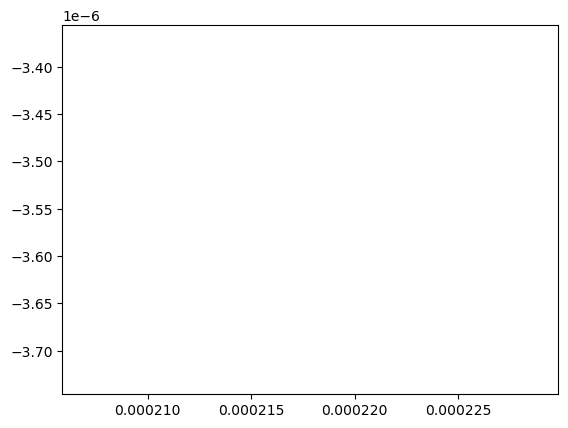

In [10]:
# read EC.csv as a pandas dataframe
df = pd.read_csv('CV-3.3.0.0__0.csv')
# plot the second collumn of df against the third collumn of df
plt.plot(df.iloc[0,2], df.iloc[0,3])

# drop the first column of df
df = df.drop(df.columns[0], axis=1)

t_max_ec = df.iloc[:,0].max()


# break up the dataframe into separate dataframes according to the the value of df["Cycle"]
df["Cycle"] = df["Cycle"].astype(int)

# group by cycle
grouped = df.groupby("Cycle")

# get the maximum value of df["Cycle"]
cycle_max=df["Cycle"].max()
print(cycle_max)
# create a new dataframe with the same number of rows as the first cycle
# but with cycle_max times as many columns
# iterate through cycles to find the dataframe with the most rows
# create a new dataframe with the same number of rows as the first cycle
# but with cycle_max times as many columns
# iterate through cycles to find the dataframe with the most rows
for i in range(cycle_max):
    if i==0:
        df_shape = df[df["Cycle"]==i].shape
        df_shaped=pd.DataFrame(np.full((df_shape[0],
                                        df_shape[1]*(cycle_max+1)),
                                        np.nan))
    elif df[df["Cycle"]==i].shape[0] > df_shape[0]:
        df_shape = df[df["Cycle"]==i].shape
        df_shaped=pd.DataFrame(np.full((df_shape[0],
                                        df_shape[1]*(cycle_max+1)),
                                        np.nan))

# the collumn names of df_shaped are the same as the collumn names of df repeated cycle_max times
print(cycle_max)

df_shaped.columns = np.tile(df.columns, cycle_max+1)

# each cycle is a set of 4 columns
j=0
for i in range(cycle_max+1):
    df_temp = df[df["Cycle"]==i]
    tempshape=df_temp.shape
    df_shaped.iloc[0:tempshape[0],j:j+4] = df_temp  #.astype(float).values
    print(df_shaped.iloc[:,j:j+4].shape)
    j += 4
df_shaped


df_shaped



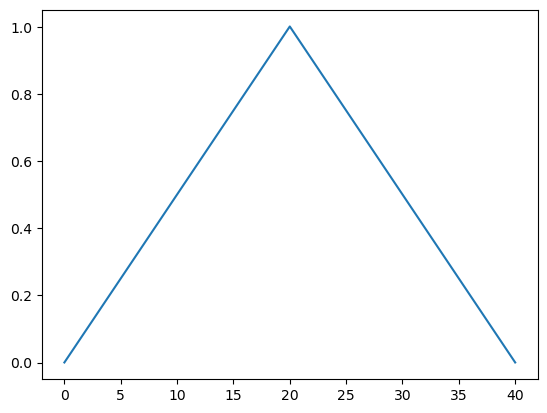

In [11]:

# plot the first and second collumns of df_shaped against each other
plt.plot(df_shaped.iloc[:,0], df_shaped.iloc[:,1])
# plot the fith and sixth collumns of df_shaped against each other
plt.plot(df_shaped.iloc[:,4], df_shaped.iloc[:,5])
# plot the ninth and tenth collumns of df_shaped against each other
#plt.plot(df_shaped.iloc[:,8], df_shaped.iloc[:,9])

# creating an intepolation function from time to potential

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Fitted parameters:
Amplitude: 1.0011326930643243
Phase: 80.01551899339779 
Offset: -14.136690122125161


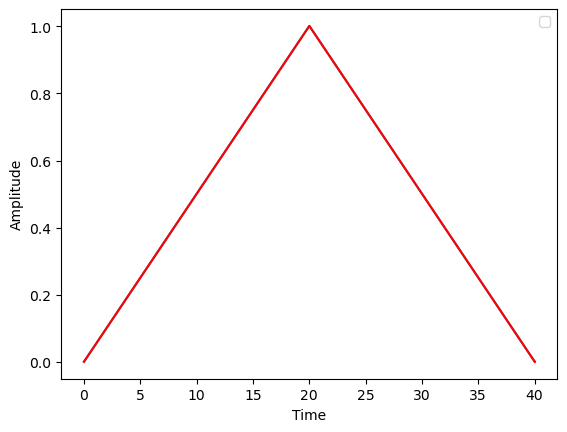

In [12]:
cycle_max=1

# here we train a sawtooth function to the E/t curve to 
# be able to convert time to potential. 
# note that the CV cycle number and the sawtooth number are realted by a factor of 2

x_data,y_data=df.iloc[:,0], df.iloc[:,1]

# Define the custom sawtooth function with phase
def sawtooth2(time, amplitude, period, phase):
    return amplitude * sawtooth((2*np.pi  * time)/(period)-phase, 0.5)

# Initial guess for the parameters [amplitude, phase]
initial_guess = [ -1, x_data.max(), 0]

# Fit the data to the custom sawtooth function
popt, pcov = curve_fit(
    sawtooth2, 
    x_data, 
    y_data, 
    p0=initial_guess, 
    method='dogbox', 
    maxfev=100000  # Increase the number of iterations
)
# Extract the optimal parameters
amplitude_fit, period_fit, phase_fit = popt

# Print the fitted parameters
print(f"Fitted parameters:\nAmplitude: {amplitude_fit}\nPhase: {period_fit} \nOffset: {phase_fit}")

# Generate fitted data
y_fit = sawtooth2(x_data, amplitude_fit, period_fit, phase_fit)

# Plot the original data and the fitted data
plt.plot(x_data, y_data )
plt.plot(x_data, y_fit, color='red')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [13]:
# Define the custom sawtooth function with phase
def sawtooth2(time, amplitude, period, phase):
    return amplitude * sawtooth((2*np.pi  * time)/(period)-phase, 0.5)




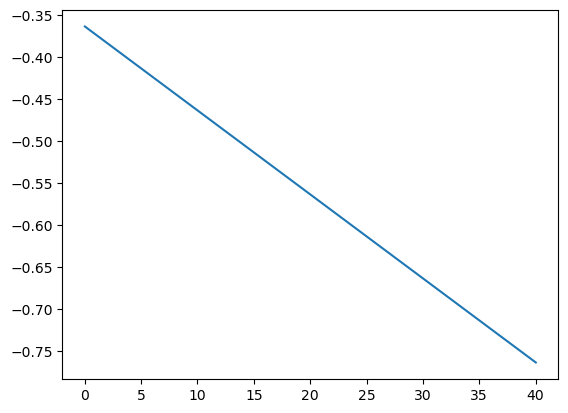

In [14]:

plt.plot(x_data, sawtooth2(x_data, 1, 400, 1))

In [15]:
df

,t_s,Ewe_V,I_A,Cycle
0,0.010000,0.000218,-0.000004,0
1,0.020000,0.000711,-0.000003,0
2,0.030000,0.001213,-0.000002,0
3,0.040000,0.001726,-0.000003,0
4,0.050000,0.002216,-0.000003,0
...,...,...,...,...
3997,39.980000,0.001719,-0.000004,0
3998,39.989998,0.001218,-0.000002,0
3999,40.000000,0.000710,-0.000003,0
4000,40.009998,0.000215,-0.000004,0


(4001, 4)
(4001, 4)


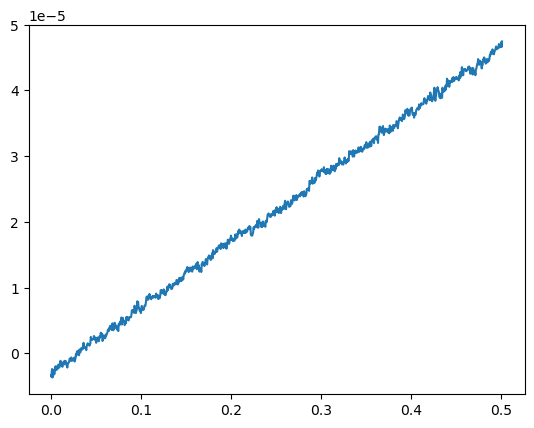

In [16]:
# read EC.csv as a pandas dataframe
df = pd.read_csv('CV-3.3.0.0__0.csv')
# plot the second collumn of df against the third collumn of df
plt.plot(df.iloc[3000:5000,2], df.iloc[3000:5000,3])

# drop the first column of df
df = df.drop(df.columns[0], axis=1)

t_max_ec = df.iloc[:,0].max()



# break up the dataframe into separate dataframes according to the the value of df["Cycle"]
df["Cycle"] = df["Cycle"].astype(int)

# group by cycle
grouped = df.groupby("Cycle")

# get the maximum value of df["Cycle"]
cycle_max=df["Cycle"].max()

# create a new dataframe with the same number of rows as the first cycle
# but with cycle_max times as many columns
# iterate through cycles to find the dataframe with the most rows
# create a new dataframe with the same number of rows as the first cycle
# but with cycle_max times as many columns
# iterate through cycles to find the dataframe with the most rows
for i in range(cycle_max):
    if i==0:
        df_shape = df[df["Cycle"]==i].shape
    elif df[df["Cycle"]==i].shape[0] > df_shape[0]:
        df_shape = df[df["Cycle"]==i].shape
        df_shaped=pd.DataFrame(np.full((df_shape[0],
                                        df_shape[1]*(cycle_max+1)
                                        ), np.nan))

# the collumn names of df_shaped are the same as the collumn names of df repeated cycle_max times


df_shaped.columns = np.tile(df.columns, cycle_max+1)

# each cycle is a set of 4 columns
j=0
for i in range(cycle_max+1):
    df_temp = df[df["Cycle"]==i]
    tempshape=df_temp.shape
    df_shaped.iloc[0:tempshape[0],j:j+4] = df_temp  #.astype(float).values
    print(df_shaped.iloc[:,j:j+4].shape)
    j += 4
df_shaped


plt.plot(df_shaped.iloc[:,5,], df_shaped.iloc[:,6,])

# reading the spectral data and performing some basic groupby operations

In [17]:
#read 20240607.pkl as a pandas dataframe
df2 = pd.read_pickle('ANDORSPEC-0.0.0.0__0.pkl')

# remove all rows where the value of the index is greater than t_max_ec this is because
# we set the spectrometer to stop after the EC measurement was finished but assume the two start at the same time
df2 = df2[df2.index < t_max_ec]

df2

,399.992645,400.206268,400.419922,400.633545,400.847198,401.060791,401.274445,401.488098,401.701721,401.915375,...,939.882324,940.091309,940.300293,940.509399,940.718384,940.927307,941.136353,941.345337,941.554321,941.763306
TT,,,,,,,,,,,,,,,,,,,,,
0.010200,13548,15049,13326,14134,14105,14347,13741,15795,12090,13062,...,13787,14213,15917,15404,14810,14733,14819,13829,14775,14192
0.020401,13517,15239,13935,14225,14574,14676,14037,16152,12244,13275,...,13389,14716,15909,15226,14712,15070,15008,13608,15547,14704
0.030601,13864,15854,13654,14571,14458,14484,14283,15857,12390,13510,...,14110,14471,15579,15659,15125,14800,15203,13794,15082,14557
0.040801,14101,15822,14076,15223,14508,15226,14581,15600,12596,13283,...,14052,14434,16059,15536,15463,14821,14868,13500,15422,14328
0.051002,14129,15039,13813,14649,14928,14678,14679,15934,12262,13020,...,14063,14361,16395,15408,15150,14770,14933,13535,15073,14663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39.975125,7536,9018,6983,8051,7995,8035,7560,9598,5763,6515,...,6278,6926,8217,8304,7597,7377,6957,5985,8243,7477
39.985325,6900,8845,6905,7988,8008,7947,7604,9430,5949,6767,...,6533,6971,8604,8066,7460,7181,6925,6404,8098,7227
39.995525,7210,9243,6911,7953,7728,8140,7570,9311,5922,6374,...,6478,6774,8611,8607,7919,6851,6905,6019,8565,7359


In [18]:
WL_mean_window=50
df2.columns = df2.columns.astype(int)
df22 = df2.groupby(df2.columns // WL_mean_window, axis=1).mean()
df22.columns = df22.columns * WL_mean_window



/var/folders/vm/d986p9hx0rlglk34b43v_h180000gn/T/ipykernel_5812/3701704272.py:3: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df22 = df2.groupby(df2.columns // WL_mean_window, axis=1).mean()


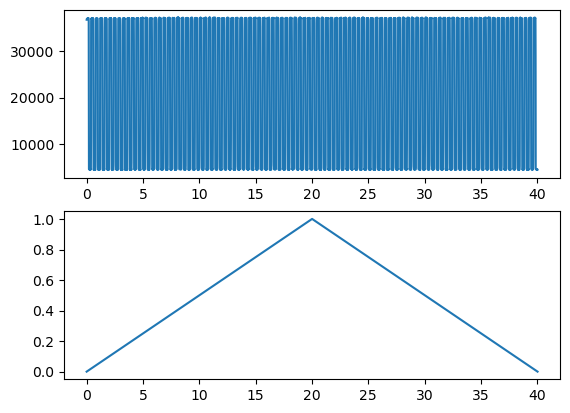

In [19]:


# apply plt.plot(df22.index.values, df22.iloc[:,10]) but smooth the second collumn  using a golay filter
from scipy.signal import savgol_filter

# create a two panel plot
fig, axs = plt.subplots(2,1)
#axs[0].plot(df22.index.values, savgol_filter(df22[560], 11, 3))
axs[0].plot(df22.index.values,df22[700])

# co plot with the potential profile 

# plot the first and second collumns of df_shaped against each other
axs[1].plot(df_shaped.iloc[:,0], df_shaped.iloc[:,1])
# plot the fith and sixth collumns of df_shaped against each other
#axs[1].plot(df_shaped.iloc[:,4], df_shaped.iloc[:,5])
# plot the ninth and tenth collumns of df_shaped against each other
#axs[1].plot(df_shaped.iloc[:,8], df_shaped.iloc[:,9])


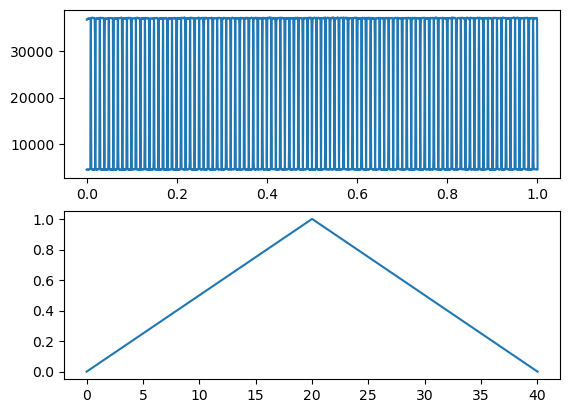

In [20]:
# convert the index of df22 to a numpy array
spectimes=df22.index.values
# interpolate the potential at the times of the spectrometer
spectra_potentials = sawtooth2(spectimes, amplitude_fit,  period_fit,phase_fit)
# plot the potential profile to check 

fig2, axs2 = plt.subplots(2,1)
axs2[0].plot(spectra_potentials,df22[700])

# plot the first and second collumns of df_shaped against each other
axs2[1].plot(df_shaped.iloc[:,0], df_shaped.iloc[:,1])
# plot the fith and sixth collumns of df_shaped against each other
#axs2[1].plot(df_shaped.iloc[:,4], df_shaped.iloc[:,5])
# plot the ninth and tenth collumns of df_shaped against each other
#axs2[1].plot(df_shaped.iloc[:,8], df_shaped.iloc[:,9])



(0.0, 1.0)

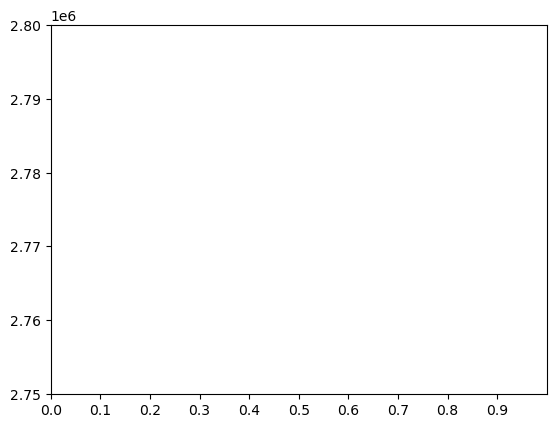

In [21]:
# create a deep copy of df22 called df22t
df22U = df22.copy(deep=True)

# set the index of df22t to the potential profile
df22U.index = spectra_potentials

plt.plot(df22U.index, df22U[700])
# set the y axis to be between 2.6 and 3 E6
plt.ylim(2.75E6, 2.8E6)


# set the x ticks to be every 0.1 V
plt.xticks(np.arange(-1, 1, 0.1));
# set the x axis to be between 0.5 and 1
plt.xlim(0, 1)


(0.0, 1.0)

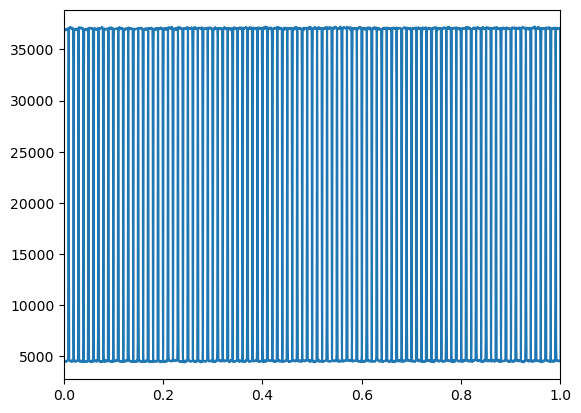

In [22]:
# plot df22U[700] against df22U.index
plt.plot(df22U.index, df22U[700])
# set the x axis to be between 0.5 and 1
plt.xlim(0,1)